# Implementation of the SPT Model - Version 2

Modifications: Johnny Esteves\ Author: Allen Pinjic - Created on June 9th, 2022

In [1]:
from astropy.io.fits import getdata
from astropy.table import Table
from astropy.cosmology import WMAP9 as cosmo

In [2]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import pylab as plt
import pymc3 as pm
import aesara
import matplotlib.font_manager
import scipy.stats
import scipy.optimize
import math

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
%matplotlib inline

In [4]:
fname = '../data_set/sptecs_catalog_oct919.fits'

data = Table(getdata(fname))
data[:2]

SPT_ID,RA,DEC,FIELD,XI,THETA_CORE,REDSHIFT,REDSHIFT_UNC,SPECZ,REDSHIFT_SOURCE,RM_PROB,CL_NOTES,M500,M500_UERR,M500_LERR,LAMBDA_CHISQ,LAMBDA_CHISQ_E,RADIO_CONTAM,STRONG_LENS,IMAGE_SOURCE,SPECZ_REF,STRONG_LENS_REF,PHOTOMETRIC_ZREF
str16,float64,float64,str11,float32,float32,float32,float32,int16,float32,float32,str50,float32,float32,float32,float32,float32,float32,float32,float32,str38,str19,str29
SPT-CLJ0000-2518,0.072338357,-25.303935,ra1hdec-25,5.073545,1.5,0.0,0.0,0,0.0,0.0,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,,,
SPT-CLJ0005-3751,1.4383179,-37.854369,ra1hdec-35,6.336327,0.75,0.48295808,0.0072415886,0,4.0,0.00061007956,-,5.419,0.887,0.887,86.40839,4.7352147,0.0,1.0,3.0,,,


In [5]:
sz_signal = np.array(data['XI'])
lambda_chisq = np.array(data['LAMBDA_CHISQ'])
lambda_chisqE = np.array(data['LAMBDA_CHISQ_E'])
redshift = np.array(data['REDSHIFT'])

(array([17., 64., 75., 45., 27., 19., 16., 13.,  7.,  7.]),
 array([14.481873, 14.530734, 14.579596, 14.628457, 14.677319, 14.726179,
        14.775041, 14.823902, 14.872764, 14.921625, 14.970487],
       dtype=float32),
 <BarContainer object of 10 artists>)

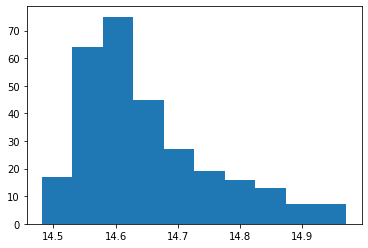

In [6]:
# Also called lambda hat (as shown in the paper)
## Shows the measured cluster richness whose values are over 20

plt.hist(np.log10(data['M500'][lambda_chisq>20]*1e14))
# Why not display values that are over 40
# "Cross matching studies, we restrict ourselves to the joint DESY1 x SPT-SZ footprint and to 𝜆 >ˆ 40"
# "We match the 𝜆 > ˆ 40 redMaPPer sample with the SPT-SZ sample selected above SZE signal to noise 𝜉 > 4"

Define the Model

In [7]:
from colossus.cosmology import cosmology
from colossus.lss import mass_function
cosmology.setCosmology('WMAP9')

def _halo_mass_function(M, z):
    return mass_function.massFunction(M, z, mdef = '500c', model = 'bocquet16')
halo_mass_function = np.vectorize(_halo_mass_function)

def E(z):
    # The Hubble constant at the value of z
    Hz = cosmo.H(z).value
    # The Hubble constant at z=0
    H0 = cosmo.H(0).value
    return (Hz/H0)

In [8]:
# LogNormal models
# see https://en.wikipedia.org/wiki/Log-normal_distribution
M0 = 3e14
Ez0 = E(0)

#Insert the priors on the SZE scaling relation parameters that identify with SZE,
# along with a value for the mass (M) and redshift (z)
## References Equation 2
def ln_zeta_given_M(theta_sze,M,z):
    A_sze, B_sze, C_sze, scatter_sze = theta_sze
    return np.log(A_sze) + (B_sze)*np.log(M/M0) + (C_sze)*(np.log(E(z)/Ez0))

#Insert the priors on the SZE scaling relation parameters that identify with LAMBDA, 
# along with a value for the mass (M) and redshift (z)
# Identified with the 
## References Equation 3
def ln_lbd_given_M(theta_lambda,M,z):
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta_lambda
    return np.log(A_lambda) + (B_lambda)*np.log(M/M0) + (C_lambda)*(np.log(E(z)/Ez0))

#Insert the value of the mean and standard deviation as the two parameters
# to find the log of the variance in a normal distribution
def logNormal_variance(mu,std):
    return (np.exp(std**2)-1)*np.exp(2*mu+std**2)
# the linear relation lnLbd and lnZeta are logNormal
# the scatter of a logNormal is different from a normal distribution

In [9]:
# set up integration vectors
mvec = np.logspace(13.8, 15.5, 75)
lbdvec = np.linspace(3,1.2*np.max(lambda_chisq),150)
zetavec = np.linspace(1,1.1*np.max(sz_signal),75)
# lbdvec = np.exp(np.arange(np.log(5),np.log(1.2*np.max(lambda_chisq)),0.032))
# zetavec = np.exp(np.arange(np.log(1),np.log(1.1*np.max(sz_signal)),0.045))

print('Vector size')
print(mvec.size)
print(lbdvec.size)
print(zetavec.size)

Vector size
75
150
75


In [10]:
zvec = np.linspace(np.min(redshift), np.max(redshift), 100)
zzv, mm = np.meshgrid(zvec, mvec)
from scipy import interpolate
halo_mass_function2 = interpolate.interp1d(zvec, halo_mass_function(mm, zzv), kind='cubic')

In [11]:
# taking only points with a significant p_chisi/lbd_hat

def slice_array(y,alpha=1e-2):
    cy = np.cumsum(y/np.sum(y),axis=0)
    ilo,iup = np.interp([alpha,1-alpha],cy,np.arange(len(y))).astype(int)+(0,2)
    return ilo, iup

In [12]:
def prob_chisi(zeta, chisi, eps=1e-12):
    res = np.exp(-(chisi-np.sqrt(zeta**2+2))**2/2.)/np.sqrt(2*np.pi)
    return res#np.where(res<eps,0.,res)

def gaussian(x,mu,std):
    return np.exp(-(x-mu)**2/std**2/2.)/np.sqrt(2*np.pi*std**2)

def prob_lbd_hat(lbd, lbd_hat, lbd_error, eps=1e-12):
    res = gaussian(lbd, lbd_hat, lbd_error)
    return res#np.where(res<eps,0.,res)

In [13]:
from scipy.integrate import simps

# given: mvec, lbdvec and zetavec

mm, zz, ll = np.meshgrid(mvec, zetavec, lbdvec, indexing='ij')

def log_likelihood_vec2(theta, z, y, yerr, eps=1e-9):
    # defining variables
    lbd_hat, chisi = y[0], y[1]
    lbd_err = yerr
    probs = []
    for lbd_hat_i, lbd_err_i, chisi_i, z_i in zip(lbd_hat, lbd_err, chisi, z):
        probs.append(_log_likelihood2(theta, lbd_hat_i, lbd_err_i, chisi_i, z_i))    
    p = np.array(probs)/np.sum(probs)
    log_p = np.where(np.isnan(log_p), -np.inf, log_p)
    return np.sum(log_p)

In [14]:
def _log_likelihood2(theta, lbd_hat_i, lbd_err_i, chisi_i, z_i):
    # unfolding theta
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]
    
    # calling predictions;
    ln_lbd_pred = ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda], mvec, z_i)
    ln_zeta_pred= ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], mvec, z_i)
    halo_mass_func = halo_mass_function2(z_i)
    
    # error probabilities
    p_chisi = prob_chisi(zetavec, chisi_i)
    p_lbd_hat = prob_lbd_hat(lbdvec, lbd_hat_i, lbd_err_i)
    
    # take only significant p_lbd_hat values
    llo, lup = slice_array(p_lbd_hat,alpha=1e-4)
    clo, cup = slice_array(p_chisi,alpha=1e-4)
    
    hmf = np.tile(halo_mass_func, (int(lup-llo), int(cup-clo), 1)).T
    ln_lbd_pred = np.tile(ln_lbd_pred, (int(lup-llo), int(cup-clo), 1)).T
    ln_zeta_pred = np.tile(ln_zeta_pred, (int(lup-llo), int(cup-clo), 1)).T
    
    # compute dn_dlbd_dzeta_integrand
    p_total_m = compute_dn_dlbd_dzeta_vec2(lbd_hat_i, lbd_err_i, chisi_i,
                                           scatter_lambda, scatter_sze, rho,
                                           ll[:,clo:cup,llo:lup],zz[:,clo:cup,llo:lup],
                                           ln_lbd_pred, ln_zeta_pred, hmf)
    # integrate over M
    p_lbd_zeta = np.trapz(p_total_m, x=mvec, axis=0)

    # integrate over zeta
    p_chisi = np.tile(p_chisi[clo:cup], (int(lup-llo), 1)).T
    p_lbd = np.trapz(p_lbd_zeta*p_chisi, x=zetavec[clo:cup], axis=0)

    # integrate over lambda
    p = np.trapz(p_lbd*p_lbd_hat[llo:lup], x=lbdvec[llo:lup], axis=0)
    return p#np.log(p)

In [15]:
def compute_dn_dlbd_dzeta_vec2(lbd_hat_i, lbd_err_i, chisi_i, scatter_lambda, scatter_sze, rho,
                               lvec, zvec, ln_lbd_pred, ln_zeta_pred, hmf):
    # converting std to normal distribution
    s_zeta = logNormal_variance(ln_zeta_pred, scatter_sze)
    s_lambda = logNormal_variance(ln_lbd_pred, scatter_lambda)
    
    # avoid error messages
    rho_inv = (1-rho**2)
    rho_inv = np.where(rho_inv<=eps, -np.inf, 1/rho_inv)

    # defining standardized variables
    lbd_std = (lvec - np.exp(ln_lbd_pred))/s_lambda
    zeta_std = (zvec - np.exp(ln_zeta_pred))/s_zeta

    # lbd_likelihood
    lp_lbd  = -rho_inv*lbd_std**2/2

    # zeta likelihood
    lp_zeta = -rho_inv*zeta_std**2/2

    # corr likelihod
    lp_corr = rho*rho_inv*lbd_std*zeta_std

    lp_total_m = lp_lbd+lp_zeta+lp_corr
    p_total_m = np.exp(lp_total_m)*hmf
    return p_total_m


In [16]:
# Implementing the log_likelihood_vec2 in the emcee code
# via writing to the prior functions.

# In reference to rho's (ρ) defintion it states:
# Parameters of the richness–mass relation defined
# in Eq. 11 (Bleem et al. 2019) 
## and the correlation coefficient, ρSZ−λ, between the SZ signal (ζ) and richness.

# ρ also defined as the correlation coefficient  
# that encodes the degree of correlation between the intrinsic scatters on the respective observables

In [17]:
Np = 100
ix = np.where(lambda_chisq>30)[0][:Np] # take 100 points

z = redshift[ix]
chisi = sz_signal[ix]
lbd_hat = lambda_chisq[ix]
lbd_err = lambda_chisqE[ix]

In [18]:
# for a given cluster, i.e. a vector (lbd_hat_i, chisi_i, z_i)

# ix = np.arange(len(lambda_chisq))[lambda_chisq>0][np.argmin(sz_signal[lambda_chisq>0])]
ix = np.arange(len(lambda_chisq))[lambda_chisq>0][np.argmax(lambda_chisq[lambda_chisq>0])]

lbd_hat_i = lambda_chisq[ix]
lbd_err_i = lambda_chisqE[ix]
chisi_i = sz_signal[ix]
z_i = redshift[ix]
print(lbd_hat_i)
print(chisi_i)

203.78017
10.641013


In [19]:
# test function 
# debuging here
eps  =1e-9
lbd  = lbd_hat[0]
zeta = chisi[0]

theta = [5.24, 1.534, 0.465, 0.161, 76.9, 1.02, 0.29, 0.16, 0.8]

In [20]:
from __future__ import print_function, division

import os
import sys
import numpy as np
import emcee

SZ_Priors = {'A_sze':[5.24, 0.85], 'B_sze':[1.534, 0.100],'C_sze':[0.465, 0.407],
             'scatter_sze':[0.161, 0.080]}

sz_theta_values = ['A_sze', 'B_sze', 'C_sze', 'scatter_sze']

Lambda_Priors = {'A_lambda':[76.9, 8.2], 'B_lambda':[1.020, 0.080],'C_lambda':[0.23, 0.16],
             'scatter_lambda':[0.23, 0.16]}

lambda_theta_values = ['A_lambda', 'B_lambda', 'C_lambda', 'scatter_lambda']

rho = theta[-1]
scatter_sze = theta[3]
scatter_lambda = theta[7]


def set_gaussian_prior(param, mu, sigma):
    return -0.5*((param - mu)/sigma)**2

# Setting SZE priors
def set_prior_sze(theta_values):
    lp = 0.
    rhomin = 0.
    rhomax = 1.
    
    for i, prior_name in enumerate(['A_sze', 'B_sze', 'C_sze', 'scatter_sze']):
        mean, error = SZ_Priors[prior_name]
        param = theta_values[i]
        lp += set_gaussian_prior(param, mean, error)
    
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range 
    lp = 0. if (scatter_sze > 0) else -np.inf
    return lp

# Setting Lambda priors
def set_prior_lambda(theta_values):
    lp = 0.
    rhomin = 0.
    rhomax = 1.
    
    for i, prior_name in enumerate(['A_lambda', 'B_lambda', 'C_lambda', 'scatter_lambda']):
        mean, error = Lambda_Priors[prior_name]
        param = theta_values[i]
        lp += set_gaussian_prior(param, mean, error)
       
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range 
    lp = 0. if (scatter_lambda > 0) else -np.inf
    return lp

def logprior(theta):
    lp = 0
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]
    
    lp_lambda = set_prior_lambda([A_lambda, B_lambda, C_lambda, scatter_lambda])
    lp_sze = set_prior_sze([A_sze, B_sze, C_sze, scatter_sze])
    
    lp = 0. if ((rho > 0) and (rho < 1)) else -np.inf
    return lp + lp_lambda + lp_sze

In [21]:
set_prior_sze([5.24, 1.534, 0.465, 0.161])

0.0

In [22]:
y = np.vstack([lbd_hat,chisi])
yerr = lbd_err
x = redshift

def logposterior(theta, x, y, yerr):
    lp = logprior(theta)
    
    # if the prior is not finite return a probability of zero (log probability of -inf)
    if not np.isfinite(lp):
        return -np.inf
    
    # return the likeihood times the prior (log likelihood plus the log prior)
    return lp + log_likelihood_vec2(theta, x, y, yerr, eps=1e-9)

In [23]:
Nburnin = 200 # number of burn-in samples
Nsamples = 400 # number of final posterior samples
walkers = 20
ndims = len(theta)
guess = (np.array(theta)[:, np.newaxis]*(1.+0.01*np.random.normal(size=(ndims,walkers)))).T

# set additional args for the posterior (the data, the noise std. dev., and the abscissa)
argslist = (x, y, yerr)

In [24]:
# set up the sampler
sampler = emcee.EnsembleSampler(walkers, ndims, logposterior, args=argslist)

# pass the initial samples and total number of samples required
sampler.run_mcmc(guess, Nsamples+Nburnin);

# extract the samples (removing the burn-in)
postsamples = sampler.chain[:, Nburnin:, :].reshape((-1, ndims))

emcee: Exception while calling your likelihood function:
  params: [ 5.26251669  1.52757733  0.47100166  0.15931978 77.11806279  1.02267806
  0.28386162  0.1591688   0.8101601 ]
  args: (array([0.        , 0.48295808, 0.114     , 0.6881156 , 0.67583644,
       0.307     , 0.317     , 0.141     , 0.7477372 , 0.352     ,
       0.1086    , 0.21966   , 0.2924    , 0.59376687, 0.52734804,
       0.        , 0.        , 0.        , 0.25757086, 0.22929814,
       0.        , 0.43099722, 0.2275    , 0.40016618, 0.39155936,
       0.413     , 0.93925875, 0.413     , 0.4010333 , 0.7198951 ,
       0.9921393 , 0.        , 0.48415172, 0.4400637 , 0.        ,
       0.87967396, 0.6348632 , 0.80812174, 0.790878  , 0.99613   ,
       0.3543809 , 0.2747654 , 0.60688525, 0.        , 0.49102753,
       0.9395654 , 0.50038975, 0.5108067 , 0.4457033 , 0.6509173 ,
       1.026627  , 0.238465  , 0.33805928, 1.37      , 0.710252  ,
       0.31729633, 0.6604971 , 0.7118231 , 0.44401142, 0.974191  ,
       0.

Traceback (most recent call last):
  File "/data0/sw/anaconda3/lib/python3.8/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-22-b17976d6fc2b>", line 13, in logposterior
    return lp + log_likelihood_vec2(theta, x, y, yerr, eps=1e-9)
  File "<ipython-input-13-aed2e47e7c2a>", line 15, in log_likelihood_vec2
    log_p = np.where(np.isnan(log_p), -np.inf, log_p)
UnboundLocalError: local variable 'log_p' referenced before assignment


UnboundLocalError: local variable 'log_p' referenced before assignment

In [ ]:
try:
    import matplotlib as mpl
    mpl.use("Agg") # force Matplotlib backend to Agg
    import corner # import corner.py
except ImportError:
    sys.exit(1)

print('Number of posterior samples is {}'.format(postsamples.shape[0]))

fig = corner.corner(postsamples, labels=[r"$m$", r"$c$"], truths=[m, c])
fig.savefig('emcee.png')